# Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install keras-flops

In [ ]:
# Load Training data
import numpy as np
images = np.load('/content/drive/MyDrive/Datasets/Numpy_BUSI/train_images.npy')
labels = np.load('/content/drive/MyDrive/Datasets/Numpy_BUSI/train_labels.npy')

# Normalize pixel values to [0, 1] range
images = images.astype('float32') / 255.0
SIZE = 224

In [ ]:
# Load Test data
test_images = np.load('/content/drive/MyDrive/Datasets/Numpy_BUSI/test_images.npy')
test_labels = np.load('/content/drive/MyDrive/Datasets/Numpy_BUSI/test_labels.npy')

# Normalize pixel values to [0, 1] range
test_images = test_images.astype('float32') / 255.0

## Plot few random samples

In [ ]:
# Define a function to plot random samples of benign and malignant images
import matplotlib.pyplot as plt
def plot_random_samples(images, labels, class_name, num_samples=3):
    # Get indices of images with the specified class
    class_indices = np.where(labels == class_name)[0]

    # Randomly select num_samples indices
    random_indices = np.random.choice(class_indices, num_samples, replace=False)

    # Create a subplots grid
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i, idx in enumerate(random_indices):
        ax = axes[i]
        ax.imshow(images[idx])
        ax.set_title(f'Sample {i+1}')
        ax.axis('off')

    plt.show()

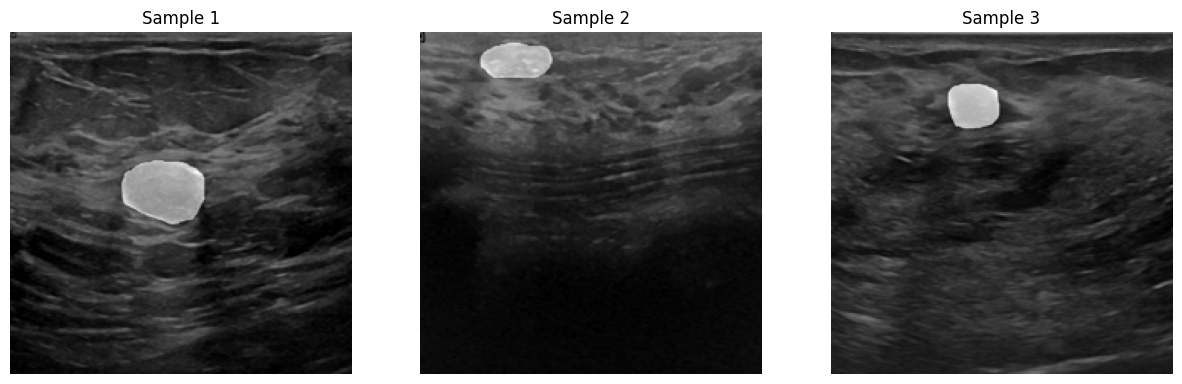

In [ ]:
# Plot 3 random samples of benign images from training data
plot_random_samples(images, labels, class_name=0, num_samples=3)

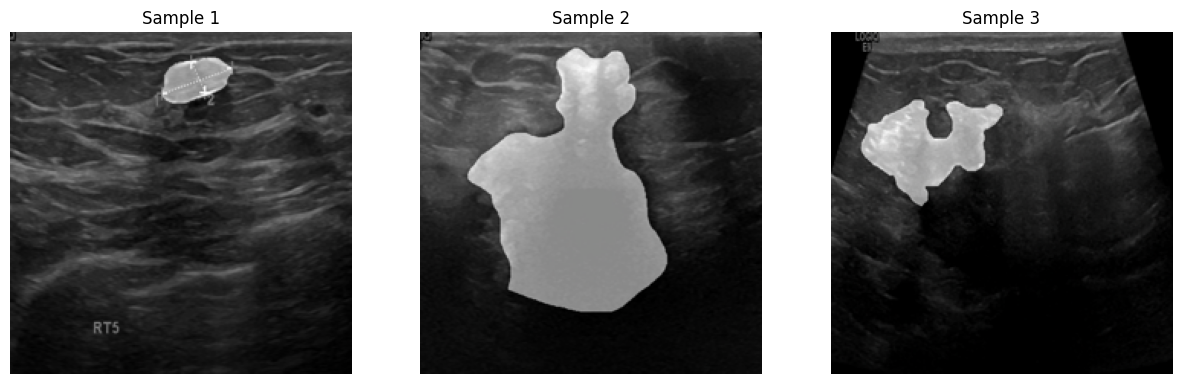

In [ ]:
# Plot 3 random samples of malignant images from training data
plot_random_samples(images, labels, class_name=1, num_samples=3)

# CNN Pre-trained Models

## Utility Functions

In [ ]:
# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, model_name):

    # Create a confusion matrix
    y_pred_binary = y_pred.round()

    cm = confusion_matrix(y_true, y_pred_binary)

    # Plot the confusion matrix as a heatmap
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.xticks([0, 1], ['Benign', 'Malignant'], fontsize=14)
    plt.yticks([0, 1], ['Benign', 'Malignant'], fontsize=14)
    plt.colorbar()

    # Add the values inside the cells
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j],
                     fontsize=20,  # specify the desired font size
                     horizontalalignment='center',
                     color='black')
    # Show the plot
    name = model_name + "Confusion_Matrix.png"
    plt.savefig(name, dpi=300)
    plt.show()

In [ ]:
# Plot ROC Curve
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(y_true, y_pred, model_name):
    # Calculate the false positive rate and true positive rate for the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver operating characteristic', fontsize=14)
    plt.legend(loc="lower right", fontsize=14)
    name = model_name + "ROC_Curve.png"
    plt.savefig(name, dpi=300)
    plt.show()

In [ ]:
# Plot training history

def plot_history(history, model_name):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochsn = np.arange(1, len(train_loss)+1)
    plt.figure(figsize = (20,7))

    plt.subplot(1,3,1)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(1,3,2)
    plt.plot(epochsn, train_acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    name = model_name + "Learning_Curves.png"
    plt.savefig(name, dpi=300)
    plt.show()

In [ ]:
import tensorflow as tf

# ResNet101V2 Model
def create_model(SIZE, model):

  for layer in model.layers:
    layer.trainable = False
  # Flatten the output layer to 1 dimension
  x = tf.keras.layers.Flatten()(model.output)

  # Add a fully connected layer with 512 hidden units and ReLU activation
  x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

  # Add a dropout rate of 0.3
  x = tf.keras.layers.Dropout(0.3)(x)

  # Add a batch normalization layer
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

  # Add a dropout rate of 0.2
  x = tf.keras.layers.Dropout(0.2)(x)

  # Add a batch normalization layer
  x = tf.keras.layers.BatchNormalization()(x)

  # Add a final sigmoid layer for classification
  output = tf.keras.layers.Dense(1 , activation='sigmoid')(x)

  model = tf.keras.Model(model.input, output)

  return model

In [ ]:
# Add early stopping and reduce learning rate callbacks

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, restore_best_weights=True, patience=20)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

## 1. ResNet101V2 Model

### Build and Compile Model

In [ ]:
# Create the final model
from keras.applications import ResNet101V2
model_name = "ResNet101V2"
model =  ResNet101V2(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
ResNet101V2_model = create_model(SIZE, model)

171317808/171317808 [==============================] - 1s 0us/step


In [ ]:
# Compile the Model
ResNet101V2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Calculae FLOPS
from keras_flops import get_flops
ResNet101V2_flops = get_flops(ResNet101V2_model, batch_size=1)

In [ ]:
print(f"FLOPS: {ResNet101V2_flops / 10 ** 9:.03} G")

FLOPS: 14.5 G


In [ ]:
# Print the summary of the model to see layer names
ResNet101V2_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

### Train Model

In [ ]:
# Train the Model
from datetime import datetime
start = datetime.now()
ResNet101V2_model_history = ResNet101V2_model.fit(images, labels, batch_size=32, epochs=200, validation_split=0.2, callbacks=[es, reduce_lr])
stop = datetime.now()

Epoch 1/200
13/13 [==============================] - 20s 618ms/step - loss: 4.9107 - accuracy: 0.8886 - val_loss: 4.4393 - val_accuracy: 0.9327 - lr: 0.0010
Epoch 2/200
13/13 [==============================] - 3s 273ms/step - loss: 3.8997 - accuracy: 0.9661 - val_loss: 3.2661 - val_accuracy: 0.9808 - lr: 0.0010
Epoch 3/200
13/13 [==============================] - 3s 257ms/step - loss: 2.8906 - accuracy: 0.9806 - val_loss: 2.4055 - val_accuracy: 0.9808 - lr: 0.0010
Epoch 4/200
13/13 [==============================] - 3s 259ms/step - loss: 2.1498 - accuracy: 0.9831 - val_loss: 1.8364 - val_accuracy: 0.9904 - lr: 0.0010
Epoch 5/200
13/13 [==============================] - 3s 254ms/step - loss: 1.6542 - accuracy: 0.9806 - val_loss: 1.4546 - val_accuracy: 0.9904 - lr: 0.0010
Epoch 6/200
13/13 [==============================] - 3s 274ms/step - loss: 1.3474 - accuracy: 0.9879 - val_loss: 1.2521 - val_accuracy: 0.9904 - lr: 0.0010
Epoch 7/200
13/13 [==============================] - 3s 258ms/s

In [ ]:
# Print the Training Time

ResNet101V2_training_time = stop - start
print('Model training time is :', ResNet101V2_training_time)

Model training time is : 0:05:00.955663


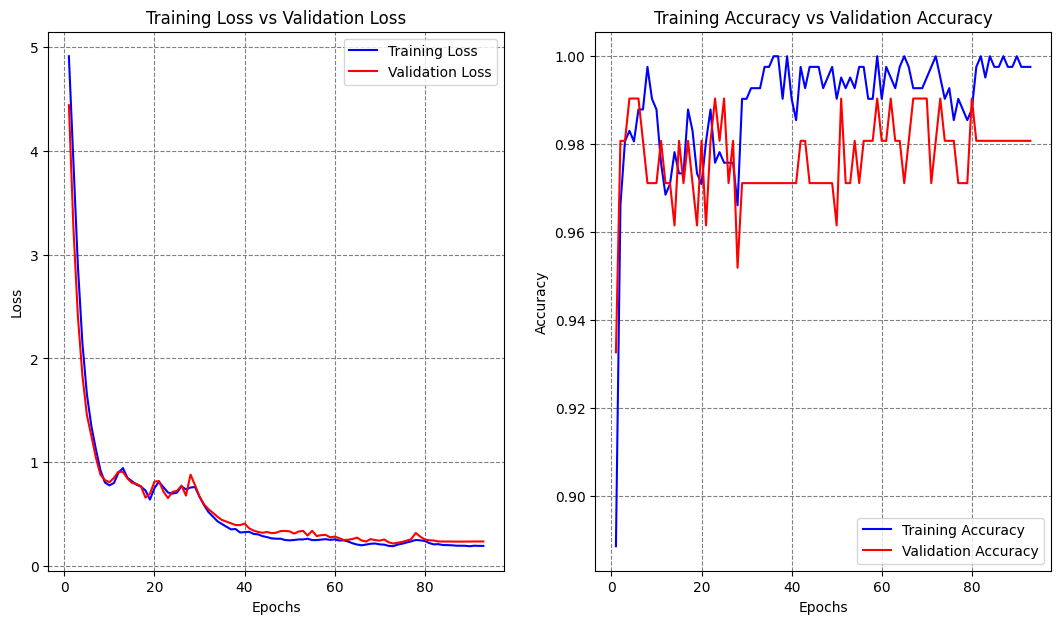

In [ ]:
# Plot the history
plot_history(ResNet101V2_model_history, model_name)

### Evaluate Model on Test data

In [ ]:
# Make predictions on the test set
ResNet101V2_y_pred = ResNet101V2_model.predict(test_images)

5/5 [==============================] - 4s 319ms/step


In [ ]:
# Calculate scores
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
ResNet101V2_accuracy = accuracy_score(test_labels, ResNet101V2_y_pred.round())
ResNet101V2_sensitivity = recall_score(test_labels, ResNet101V2_y_pred.round())
ResNet101V2_specificity = recall_score(test_labels, ResNet101V2_y_pred.round(), pos_label=0)
ResNet101V2_f1 = f1_score(test_labels, ResNet101V2_y_pred.round())
ResNet101V2_roc = roc_auc_score(test_labels, ResNet101V2_y_pred)

In [ ]:
# Print the results
print("Scores of ResNet101V2 Model")
print("==================================================")
print("ResNet101V2_Accuracy score: %.4f" % (ResNet101V2_accuracy))
print("ResNet101V2_Sensitivity score: %.4f" % (ResNet101V2_sensitivity))
print("ResNet101V2_Specificity score: %.4f" % (ResNet101V2_specificity))
print("ResNet101V2_F1 score: %.4f" % (ResNet101V2_f1))
print("ResNet101V2_roc_auc score: %.4f" % (ResNet101V2_roc))
print("==================================================")

Scores of ResNet101V2 Model
ResNet101V2_Accuracy score: 0.9615
ResNet101V2_Sensitivity score: 0.8974
ResNet101V2_Specificity score: 0.9890
ResNet101V2_F1 score: 0.9333
ResNet101V2_roc_auc score: 0.9893


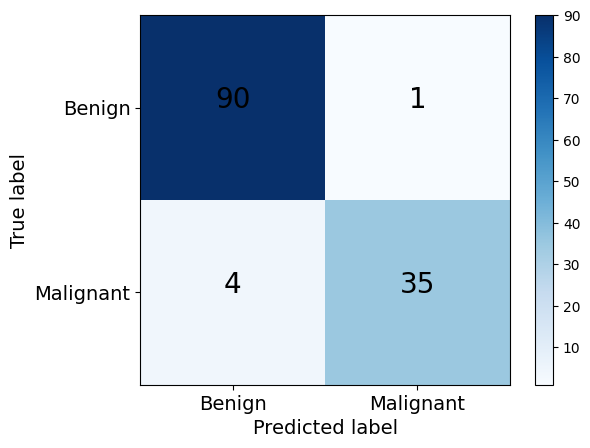

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(test_labels, ResNet101V2_y_pred, model_name)

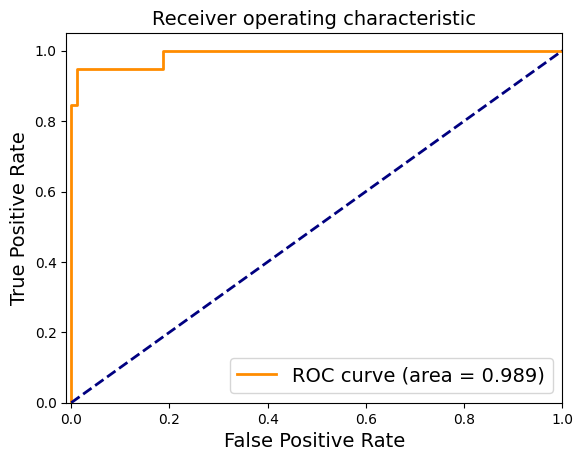

In [ ]:
# Plot ROC Curve

plot_roc_curve(test_labels, ResNet101V2_y_pred, model_name)

## 2. VGG16 Model

### Build and Compile Model

In [ ]:
# Create the final model
from keras.applications.vgg16 import VGG16
model_name = "VGG16"
model =  VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
VGG16_model = create_model(SIZE, model)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Compile the Model
VGG16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Calculae FLOPS
from keras_flops import get_flops
VGG16_flops = get_flops(VGG16_model, batch_size=1)

In [ ]:
print(f"FLOPS: {VGG16_flops / 10 ** 9:.03} G")

FLOPS: 30.7 G


In [ ]:
# Print the summary of the model to see layer names
VGG16_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### Train Model

In [ ]:
# Train the Model
from datetime import datetime
start = datetime.now()
VGG16_model_history = VGG16_model.fit(images, labels, batch_size=32, epochs=200, validation_split=0.2, callbacks=[es, reduce_lr])
stop = datetime.now()

Epoch 1/200
13/13 [==============================] - 17s 727ms/step - loss: 5.0008 - accuracy: 0.7312 - val_loss: 3.5084 - val_accuracy: 0.8173 - lr: 0.0010
Epoch 2/200
13/13 [==============================] - 3s 205ms/step - loss: 3.1678 - accuracy: 0.9056 - val_loss: 2.7852 - val_accuracy: 0.9519 - lr: 0.0010
Epoch 3/200
13/13 [==============================] - 3s 205ms/step - loss: 2.5400 - accuracy: 0.9370 - val_loss: 2.2095 - val_accuracy: 0.9519 - lr: 0.0010
Epoch 4/200
13/13 [==============================] - 3s 204ms/step - loss: 2.0335 - accuracy: 0.9540 - val_loss: 1.7932 - val_accuracy: 0.9615 - lr: 0.0010
Epoch 5/200
13/13 [==============================] - 2s 192ms/step - loss: 1.6663 - accuracy: 0.9637 - val_loss: 1.5151 - val_accuracy: 0.9904 - lr: 0.0010
Epoch 6/200
13/13 [==============================] - 2s 190ms/step - loss: 1.3977 - accuracy: 0.9685 - val_loss: 1.7347 - val_accuracy: 0.6827 - lr: 0.0010
Epoch 7/200
13/13 [==============================] - 3s 209ms/s

In [ ]:
# Print the Training Time

VGG16_training_time = stop - start
print('Model training time is :', VGG16_training_time)

Model training time is : 0:09:24.129053


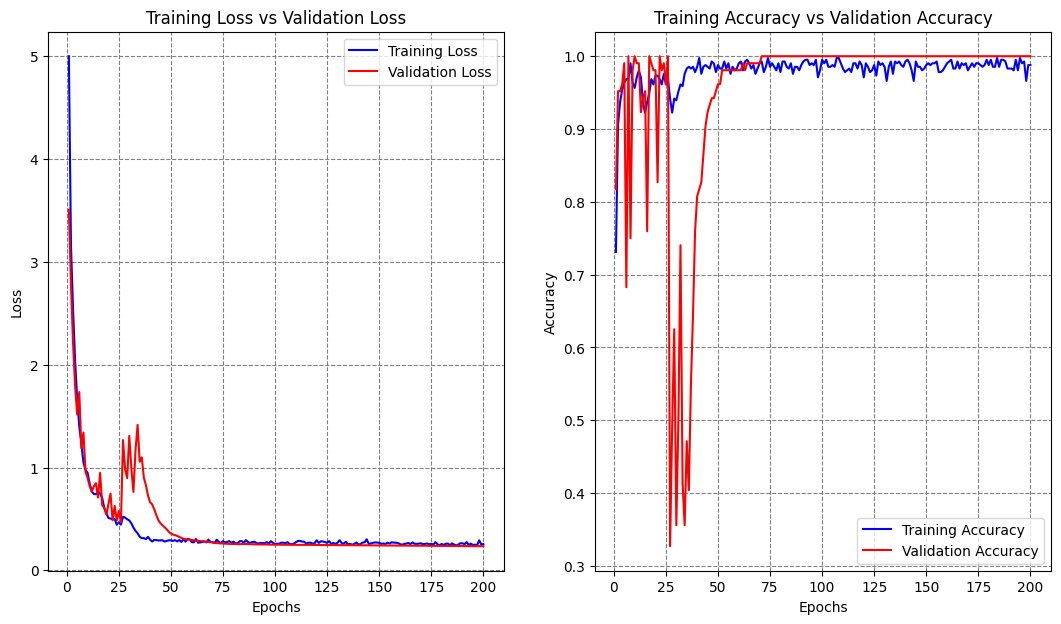

In [ ]:
# Plot the history
plot_history(VGG16_model_history, model_name)

### Evaluate Model on Test data

In [ ]:
# Make predictions on the test set
VGG16_y_pred = VGG16_model.predict(test_images)

5/5 [==============================] - 2s 316ms/step


In [ ]:
# Calculate scores
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
VGG16_accuracy = accuracy_score(test_labels, VGG16_y_pred.round())
VGG16_sensitivity = recall_score(test_labels, VGG16_y_pred.round())
VGG16_specificity = recall_score(test_labels, VGG16_y_pred.round(), pos_label=0)
VGG16_f1 = f1_score(test_labels, VGG16_y_pred.round())
VGG16_roc = roc_auc_score(test_labels, VGG16_y_pred)

In [ ]:
# Print the results
print("Scores of VGG16 Model")
print("==================================================")
print("VGG16_Accuracy score: %.4f" % (VGG16_accuracy))
print("VGG16_Sensitivity score: %.4f" % (VGG16_sensitivity))
print("VGG16_Specificity score: %.4f" % (VGG16_specificity))
print("VGG16_F1 score: %.4f" % (VGG16_f1))
print("VGG16_roc_auc score: %.4f" % (VGG16_roc))
print("==================================================")

Scores of VGG16 Model
VGG16_Accuracy score: 0.9692
VGG16_Sensitivity score: 0.9231
VGG16_Specificity score: 0.9890
VGG16_F1 score: 0.9474
VGG16_roc_auc score: 0.9966


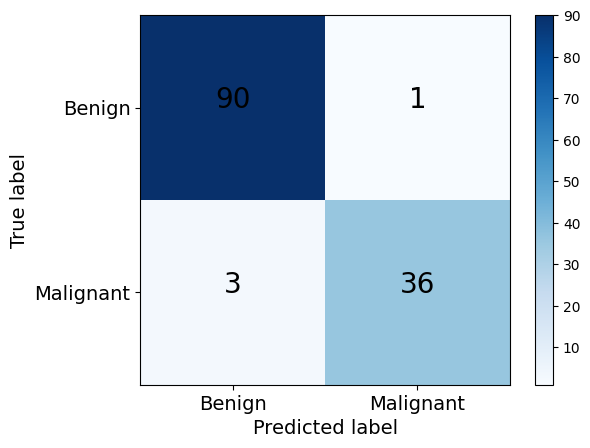

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(test_labels, VGG16_y_pred, model_name)

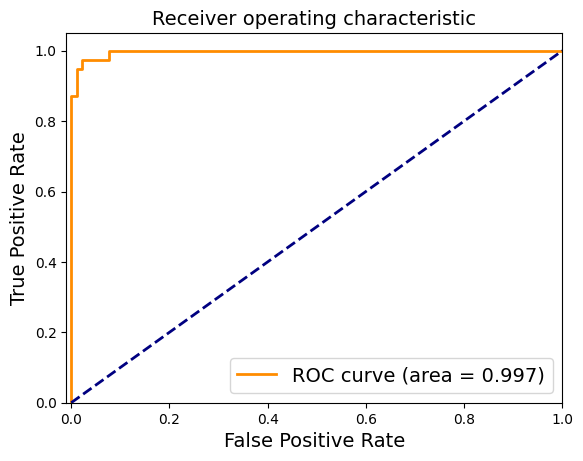

In [ ]:
# Plot ROC Curve

plot_roc_curve(test_labels, VGG16_y_pred, model_name)

## 3. ResNet50 Model

### Build and Compile Model

In [ ]:
# Create the final model
from keras.applications import ResNet50
model_name = "ResNet50"
model =  ResNet50(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
ResNet50_model = create_model(SIZE, model)

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
# Compile the Model
ResNet50_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Calculae FLOPS
from keras_flops import get_flops
ResNet50_flops = get_flops(ResNet50_model, batch_size=1)

In [ ]:
print(f"FLOPS: {ResNet50_flops / 10 ** 9:.03} G")

FLOPS: 7.8 G


In [ ]:
# Print the summary of the model to see layer names
ResNet50_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

### Train Model

In [ ]:
# Train the Model
from datetime import datetime
start = datetime.now()
ResNet50_model_history = ResNet50_model.fit(images, labels, batch_size=32, epochs=200, validation_split=0.2, callbacks=[es, reduce_lr])
stop = datetime.now()

Epoch 1/200
13/13 [==============================] - 12s 377ms/step - loss: 3.7875 - accuracy: 0.5521 - val_loss: 3.0785 - val_accuracy: 0.3365 - lr: 0.0010
Epoch 2/200
13/13 [==============================] - 2s 172ms/step - loss: 2.7356 - accuracy: 0.5472 - val_loss: 2.3042 - val_accuracy: 0.6731 - lr: 0.0010
Epoch 3/200
13/13 [==============================] - 2s 179ms/step - loss: 2.3279 - accuracy: 0.5884 - val_loss: 2.0651 - val_accuracy: 0.6731 - lr: 0.0010
Epoch 4/200
13/13 [==============================] - 2s 179ms/step - loss: 2.0535 - accuracy: 0.5932 - val_loss: 1.8775 - val_accuracy: 0.6731 - lr: 0.0010
Epoch 5/200
13/13 [==============================] - 2s 147ms/step - loss: 1.9403 - accuracy: 0.5496 - val_loss: 1.7293 - val_accuracy: 0.6731 - lr: 0.0010
Epoch 6/200
13/13 [==============================] - 2s 174ms/step - loss: 1.7723 - accuracy: 0.5908 - val_loss: 1.6185 - val_accuracy: 0.6731 - lr: 0.0010
Epoch 7/200
13/13 [==============================] - 2s 176ms/s

In [ ]:
# Print the Training Time

ResNet50_training_time = stop - start
print('Model training time is :', ResNet50_training_time)

Model training time is : 0:01:44.061183


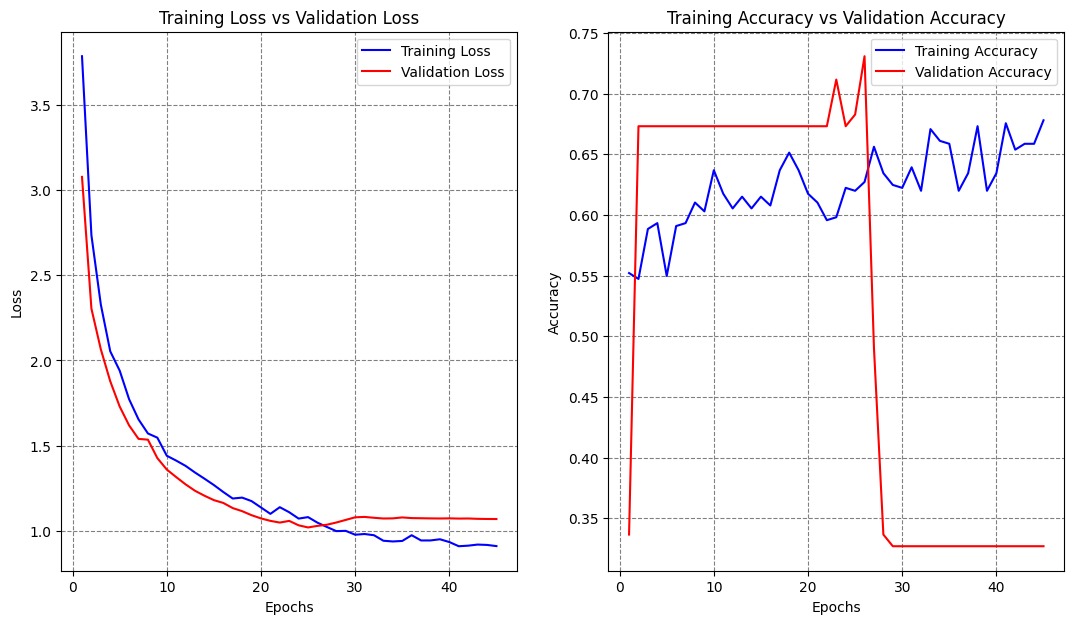

In [ ]:
# Plot the history
plot_history(ResNet50_model_history, model_name)

### Evaluate Model on Test data

In [ ]:
# Make predictions on the test set
ResNet50_y_pred = ResNet50_model.predict(test_images)

5/5 [==============================] - 2s 166ms/step


In [ ]:
# Calculate scores
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
ResNet50_accuracy = accuracy_score(test_labels, ResNet50_y_pred.round())
ResNet50_sensitivity = recall_score(test_labels, ResNet50_y_pred.round())
ResNet50_specificity = recall_score(test_labels, ResNet50_y_pred.round(), pos_label=0)
ResNet50_f1 = f1_score(test_labels, ResNet50_y_pred.round())
ResNet50_roc = roc_auc_score(test_labels, ResNet50_y_pred)

In [ ]:
# Print the results
print("Scores of ResNet50 Model")
print("==================================================")
print("ResNet50_Accuracy score: %.4f" % (ResNet50_accuracy))
print("ResNet50_Sensitivity score: %.4f" % (ResNet50_sensitivity))
print("ResNet50_Specificity score: %.4f" % (ResNet50_specificity))
print("ResNet50_F1 score: %.4f" % (ResNet50_f1))
print("ResNet50_roc_auc score: %.4f" % (ResNet50_roc))
print("==================================================")

Scores of ResNet50 Model
ResNet50_Accuracy score: 0.7077
ResNet50_Sensitivity score: 0.0256
ResNet50_Specificity score: 1.0000
ResNet50_F1 score: 0.0500
ResNet50_roc_auc score: 0.8197


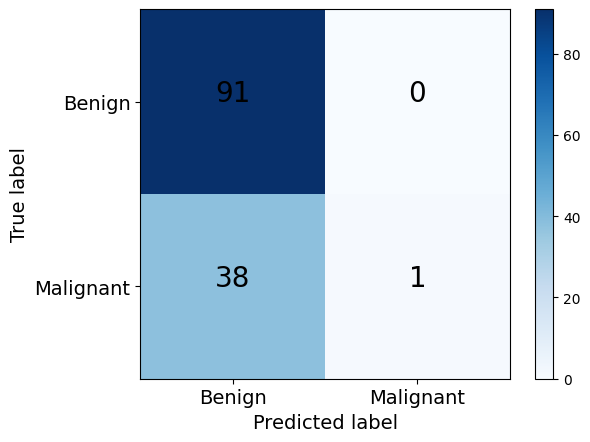

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(test_labels, ResNet50_y_pred, model_name)

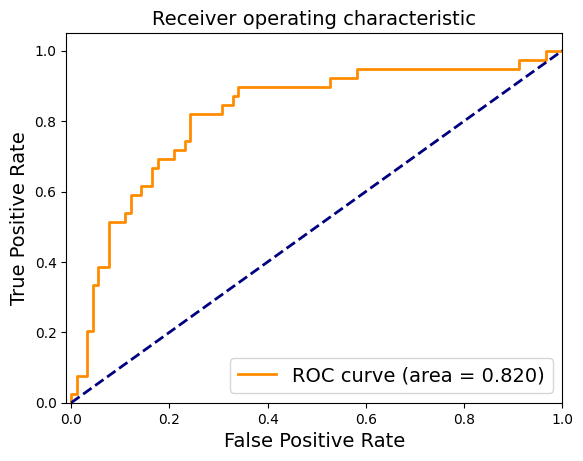

In [ ]:
# Plot ROC Curve

plot_roc_curve(test_labels, ResNet50_y_pred, model_name)

## 4. DenseNet121 Model

### Build and Compile Model

In [ ]:
# Create the final model
from keras.applications import DenseNet121
model_name = "DenseNet121"
model =  DenseNet121(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
DenseNet121_model = create_model(SIZE, model)

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
# Compile the Model
DenseNet121_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Calculae FLOPS
from keras_flops import get_flops
DenseNet121_flops = get_flops(DenseNet121_model, batch_size=1)

In [ ]:
print(f"FLOPS: {DenseNet121_flops / 10 ** 9:.03} G")

FLOPS: 5.73 G


In [ ]:
# Print the summary of the model to see layer names
DenseNet121_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

### Train Model

In [ ]:
# Train the Model
from datetime import datetime
start = datetime.now()
DenseNet121_model_history = DenseNet121_model.fit(images, labels, batch_size=32, epochs=200, validation_split=0.2, callbacks=[es, reduce_lr])
stop = datetime.now()

Epoch 1/200
13/13 [==============================] - 22s 689ms/step - loss: 5.2358 - accuracy: 0.8305 - val_loss: 4.1152 - val_accuracy: 0.9519 - lr: 0.0010
Epoch 2/200
13/13 [==============================] - 3s 216ms/step - loss: 3.8690 - accuracy: 0.9685 - val_loss: 3.2993 - val_accuracy: 0.9712 - lr: 0.0010
Epoch 3/200
13/13 [==============================] - 2s 158ms/step - loss: 2.9811 - accuracy: 0.9709 - val_loss: 2.5647 - val_accuracy: 0.9808 - lr: 0.0010
Epoch 4/200
13/13 [==============================] - 2s 179ms/step - loss: 2.3183 - accuracy: 0.9758 - val_loss: 2.0316 - val_accuracy: 0.9808 - lr: 0.0010
Epoch 5/200
13/13 [==============================] - 2s 153ms/step - loss: 1.8568 - accuracy: 0.9806 - val_loss: 1.6659 - val_accuracy: 0.9808 - lr: 0.0010
Epoch 6/200
13/13 [==============================] - 2s 177ms/step - loss: 1.5024 - accuracy: 0.9927 - val_loss: 1.4020 - val_accuracy: 0.9808 - lr: 0.0010
Epoch 7/200
13/13 [==============================] - 2s 184ms/s

In [ ]:
# Print the Training Time

DenseNet121_training_time = stop - start
print('Model training time is :', DenseNet121_training_time)

Model training time is : 0:04:39.167292


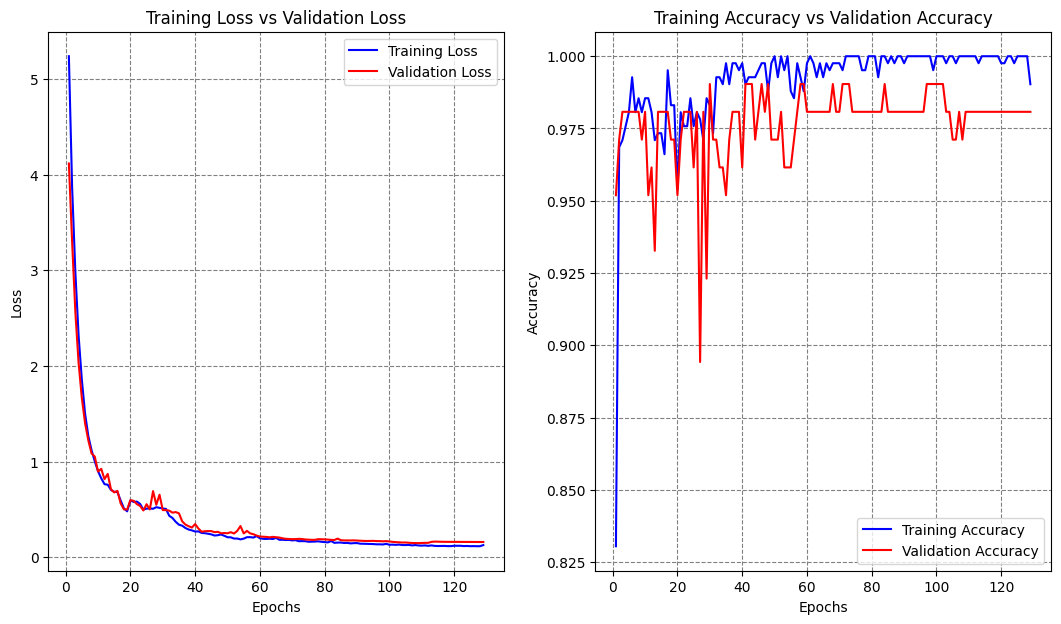

In [ ]:
# Plot the history
plot_history(DenseNet121_model_history, model_name)

### Evaluate Model on Test data

In [ ]:
# Make predictions on the test set
DenseNet121_y_pred = DenseNet121_model.predict(test_images)

5/5 [==============================] - 5s 429ms/step


In [ ]:
# Calculate scores
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
DenseNet121_accuracy = accuracy_score(test_labels, DenseNet121_y_pred.round())
DenseNet121_sensitivity = recall_score(test_labels, DenseNet121_y_pred.round())
DenseNet121_specificity = recall_score(test_labels, DenseNet121_y_pred.round(), pos_label=0)
DenseNet121_f1 = f1_score(test_labels, DenseNet121_y_pred.round())
DenseNet121_roc = roc_auc_score(test_labels, DenseNet121_y_pred)

In [ ]:
# Print the results
print("Scores of DenseNet121 Model")
print("==================================================")
print("DenseNet121_Accuracy score: %.4f" % (DenseNet121_accuracy))
print("DenseNet121_Sensitivity score: %.4f" % (DenseNet121_sensitivity))
print("DenseNet121_Specificity score: %.4f" % (DenseNet121_specificity))
print("DenseNet121_F1 score: %.4f" % (DenseNet121_f1))
print("DenseNet121_roc_auc score: %.4f" % (DenseNet121_roc))
print("==================================================")

Scores of DenseNet121 Model
DenseNet121_Accuracy score: 0.9615
DenseNet121_Sensitivity score: 0.8974
DenseNet121_Specificity score: 0.9890
DenseNet121_F1 score: 0.9333
DenseNet121_roc_auc score: 0.9972


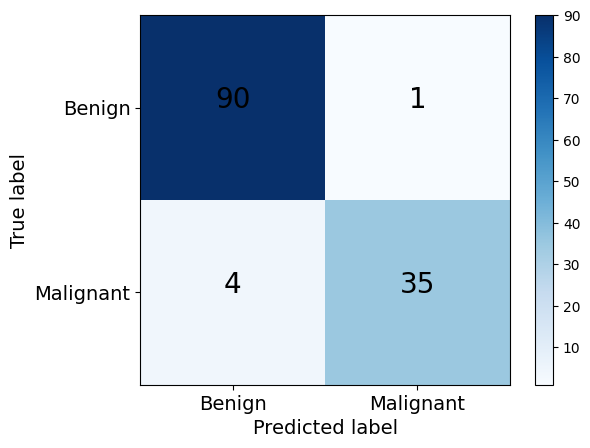

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(test_labels, DenseNet121_y_pred, model_name)

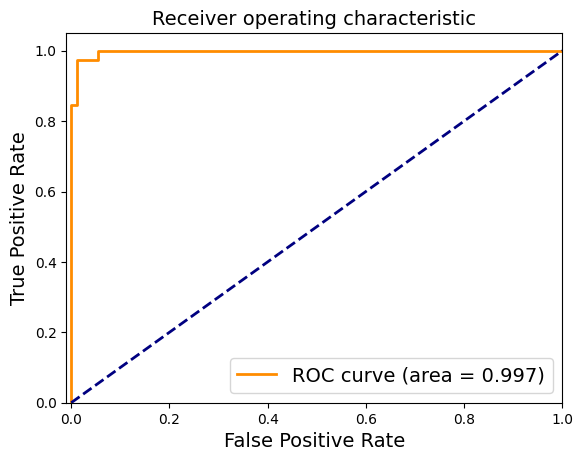

In [ ]:
# Plot ROC Curve

plot_roc_curve(test_labels, DenseNet121_y_pred, model_name)

## 5. InceptionV3 Model

### Build and Compile Model

In [ ]:
# Create the final model
from keras.applications import InceptionV3
model_name = "InceptionV3"
model =  InceptionV3(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
InceptionV3_model = create_model(SIZE, model)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
# Compile the Model
InceptionV3_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Calculae FLOPS
from keras_flops import get_flops
InceptionV3_flops = get_flops(InceptionV3_model, batch_size=1)

In [ ]:
print(f"FLOPS: {InceptionV3_flops / 10 ** 9:.03} G")

FLOPS: 5.72 G


In [ ]:
# Print the summary of the model to see layer names
InceptionV3_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_10 (BatchN  (None, 111, 111, 32  96         ['conv2d_4[0][0]']               
 ormalization)                  )                                                           

### Train Model

In [ ]:
# Train the Model
from datetime import datetime
start = datetime.now()
InceptionV3_model_history = InceptionV3_model.fit(images, labels, batch_size=32, epochs=200, validation_split=0.2, callbacks=[es, reduce_lr])
stop = datetime.now()

Epoch 1/200
13/13 [==============================] - 18s 601ms/step - loss: 6.8605 - accuracy: 0.8717 - val_loss: 6.2064 - val_accuracy: 0.9519 - lr: 0.0010
Epoch 2/200
13/13 [==============================] - 2s 123ms/step - loss: 5.5882 - accuracy: 0.9564 - val_loss: 4.7394 - val_accuracy: 0.9615 - lr: 0.0010
Epoch 3/200
13/13 [==============================] - 2s 134ms/step - loss: 4.0838 - accuracy: 0.9588 - val_loss: 3.3916 - val_accuracy: 0.9519 - lr: 0.0010
Epoch 4/200
13/13 [==============================] - 2s 136ms/step - loss: 2.9582 - accuracy: 0.9782 - val_loss: 2.5738 - val_accuracy: 0.9615 - lr: 0.0010
Epoch 5/200
13/13 [==============================] - 2s 123ms/step - loss: 2.2089 - accuracy: 0.9855 - val_loss: 2.0012 - val_accuracy: 0.9615 - lr: 0.0010
Epoch 6/200
13/13 [==============================] - 1s 118ms/step - loss: 1.7353 - accuracy: 0.9806 - val_loss: 1.6982 - val_accuracy: 0.9423 - lr: 0.0010
Epoch 7/200
13/13 [==============================] - 1s 117ms/s

In [ ]:
# Print the Training Time

InceptionV3_training_time = stop - start
print('Model training time is :', InceptionV3_training_time)

Model training time is : 0:05:11.480720


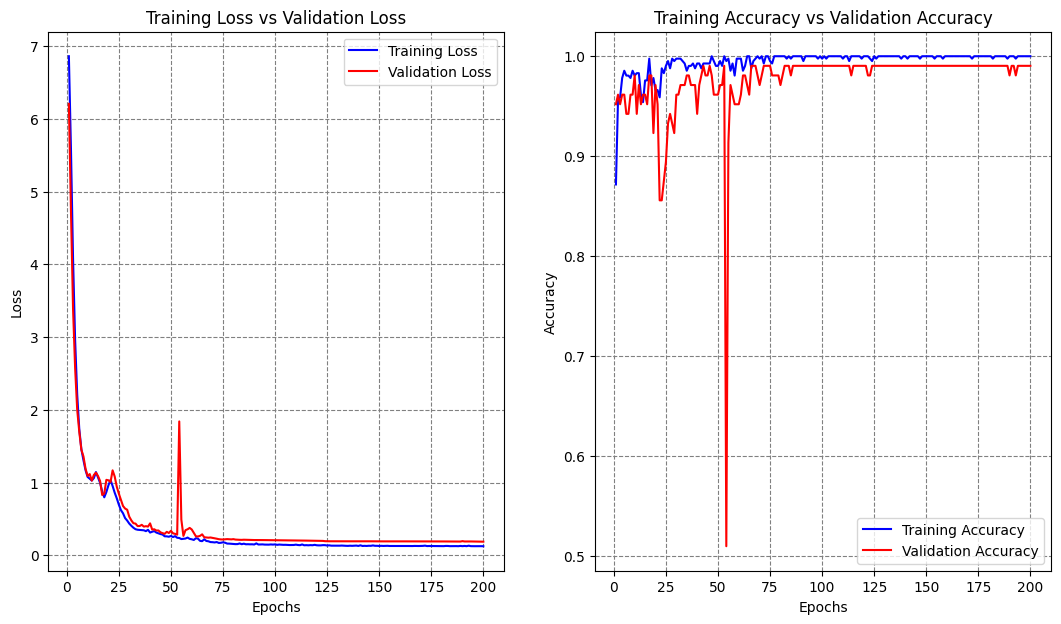

In [ ]:
# Plot the history
plot_history(InceptionV3_model_history, model_name)

### Evaluate Model on Test data

In [ ]:
# Make predictions on the test set
InceptionV3_y_pred = InceptionV3_model.predict(test_images)

5/5 [==============================] - 3s 344ms/step


In [ ]:
# Calculate scores
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
InceptionV3_accuracy = accuracy_score(test_labels, InceptionV3_y_pred.round())
InceptionV3_sensitivity = recall_score(test_labels, InceptionV3_y_pred.round())
InceptionV3_specificity = recall_score(test_labels, InceptionV3_y_pred.round(), pos_label=0)
InceptionV3_f1 = f1_score(test_labels, InceptionV3_y_pred.round())
InceptionV3_roc = roc_auc_score(test_labels, InceptionV3_y_pred)

In [ ]:
# Print the results
print("Scores of InceptionV3 Model")
print("==================================================")
print("InceptionV3_Accuracy score: %.4f" % (InceptionV3_accuracy))
print("InceptionV3_Sensitivity score: %.4f" % (InceptionV3_sensitivity))
print("InceptionV3_Specificity score: %.4f" % (InceptionV3_specificity))
print("InceptionV3_F1 score: %.4f" % (InceptionV3_f1))
print("InceptionV3_roc_auc score: %.4f" % (InceptionV3_roc))
print("==================================================")

Scores of InceptionV3 Model
InceptionV3_Accuracy score: 0.9692
InceptionV3_Sensitivity score: 0.8974
InceptionV3_Specificity score: 1.0000
InceptionV3_F1 score: 0.9459
InceptionV3_roc_auc score: 0.9980


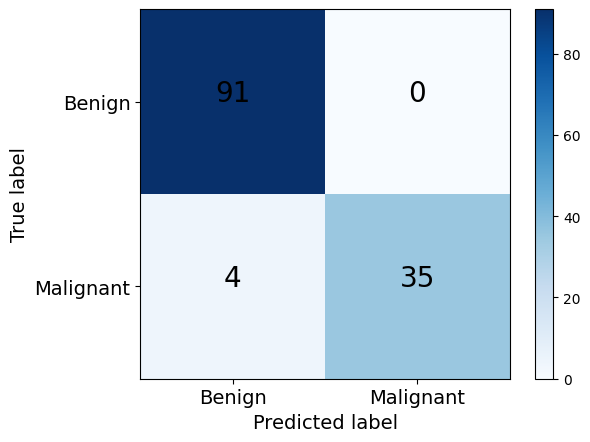

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(test_labels, InceptionV3_y_pred, model_name)

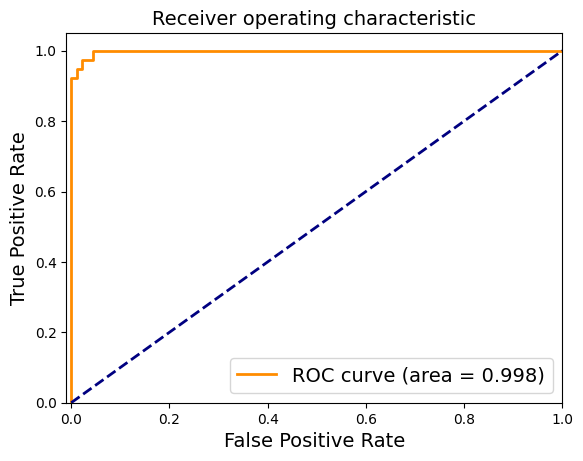

In [ ]:
# Plot ROC Curve

plot_roc_curve(test_labels, InceptionV3_y_pred, model_name)

## 6. MobileNet Model

### Build and Compile Model

In [ ]:
# Create the final model
from keras.applications import MobileNet
model_name = "MobileNet"
model =  MobileNet(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
MobileNet_model = create_model(SIZE, model)

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
# Compile the Model
MobileNet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Calculae FLOPS
from keras_flops import get_flops
MobileNet_flops = get_flops(MobileNet_model, batch_size=1)

In [ ]:
print(f"FLOPS: {MobileNet_flops / 10 ** 9:.03} G")

FLOPS: 1.17 G


In [ ]:
# Print the summary of the model to see layer names
MobileNet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

### Train Model

In [ ]:
# Train the Model
from datetime import datetime
start = datetime.now()
MobileNet_model_history = MobileNet_model.fit(images, labels, batch_size=32, epochs=200, validation_split=0.2, callbacks=[es, reduce_lr])
stop = datetime.now()

Epoch 1/200
13/13 [==============================] - 15s 196ms/step - loss: 5.7326 - accuracy: 0.8935 - val_loss: 4.9730 - val_accuracy: 0.9904 - lr: 0.0010
Epoch 2/200
13/13 [==============================] - 1s 67ms/step - loss: 4.6859 - accuracy: 0.9758 - val_loss: 4.0786 - val_accuracy: 0.9904 - lr: 0.0010
Epoch 3/200
13/13 [==============================] - 1s 68ms/step - loss: 3.6666 - accuracy: 0.9758 - val_loss: 3.1036 - val_accuracy: 0.9904 - lr: 0.0010
Epoch 4/200
13/13 [==============================] - 1s 67ms/step - loss: 2.7816 - accuracy: 0.9806 - val_loss: 2.3941 - val_accuracy: 0.9904 - lr: 0.0010
Epoch 5/200
13/13 [==============================] - 1s 68ms/step - loss: 2.1455 - accuracy: 0.9952 - val_loss: 1.8845 - val_accuracy: 0.9904 - lr: 0.0010
Epoch 6/200
13/13 [==============================] - 1s 67ms/step - loss: 1.6913 - accuracy: 0.9879 - val_loss: 1.5241 - val_accuracy: 0.9904 - lr: 0.0010
Epoch 7/200
13/13 [==============================] - 1s 71ms/step - 

In [ ]:
# Print the Training Time

MobileNet_training_time = stop - start
print('Model training time is :', MobileNet_training_time)

Model training time is : 0:01:26.354123


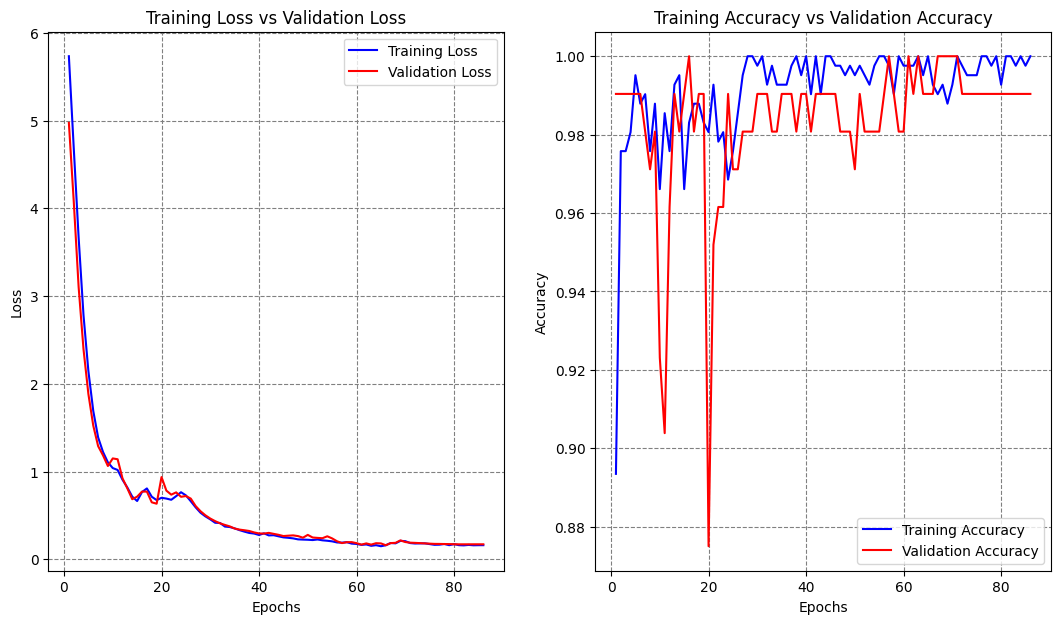

In [ ]:
# Plot the history
plot_history(MobileNet_model_history, model_name)

### Evaluate Model on Test data

In [ ]:
# Make predictions on the test set
MobileNet_y_pred = MobileNet_model.predict(test_images)

5/5 [==============================] - 1s 108ms/step


In [ ]:
# Calculate scores
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
MobileNet_accuracy = accuracy_score(test_labels, MobileNet_y_pred.round())
MobileNet_sensitivity = recall_score(test_labels, MobileNet_y_pred.round())
MobileNet_specificity = recall_score(test_labels, MobileNet_y_pred.round(), pos_label=0)
MobileNet_f1 = f1_score(test_labels, MobileNet_y_pred.round())
MobileNet_roc = roc_auc_score(test_labels, MobileNet_y_pred)

In [ ]:
# Print the results
print("Scores of MobileNet Model")
print("==================================================")
print("MobileNet_Accuracy score: %.4f" % (MobileNet_accuracy))
print("MobileNet_Sensitivity score: %.4f" % (MobileNet_sensitivity))
print("MobileNet_Specificity score: %.4f" % (MobileNet_specificity))
print("MobileNet_F1 score: %.4f" % (MobileNet_f1))
print("MobileNet_roc_auc score: %.4f" % (MobileNet_roc))
print("==================================================")

Scores of MobileNet Model
MobileNet_Accuracy score: 0.9769
MobileNet_Sensitivity score: 0.9487
MobileNet_Specificity score: 0.9890
MobileNet_F1 score: 0.9610
MobileNet_roc_auc score: 0.9938


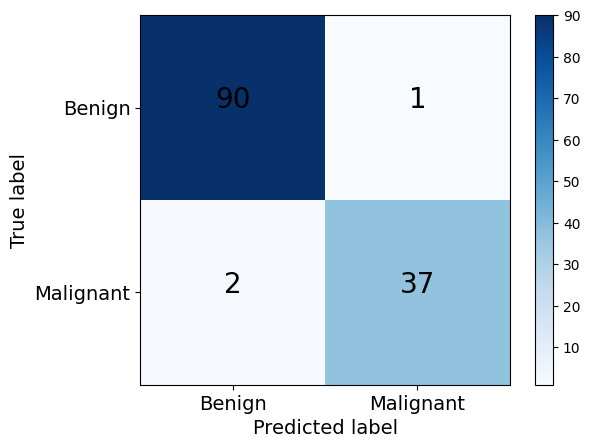

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(test_labels, MobileNet_y_pred, model_name)

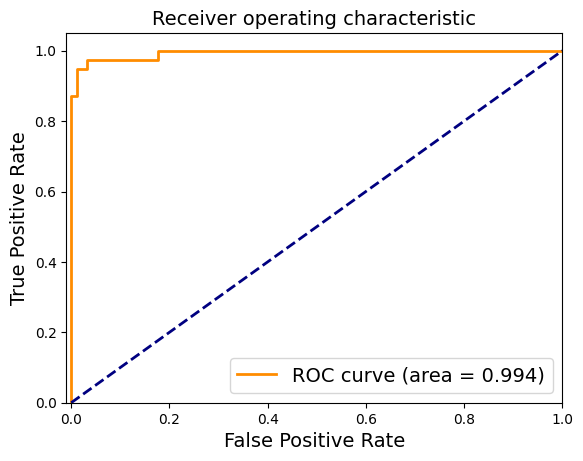

In [ ]:
# Plot ROC Curve

plot_roc_curve(test_labels, MobileNet_y_pred, model_name)

## 7. Xception Model

### Build and Compile Model

In [ ]:
# Create the final model
from keras.applications import Xception
model_name = "Xception"
model =  Xception(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
Xception_model = create_model(SIZE, model)

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
# Compile the Model
Xception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Calculae FLOPS
from keras_flops import get_flops
Xception_flops = get_flops(Xception_model, batch_size=1)

In [ ]:
print(f"FLOPS: {Xception_flops / 10 ** 9:.03} G")

FLOPS: 9.19 G


In [ ]:
# Print the summary of the model to see layer names
Xception_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

### Train Model

In [ ]:
# Train the Model
from datetime import datetime
start = datetime.now()
Xception_model_history = Xception_model.fit(images, labels, batch_size=32, epochs=200, validation_split=0.2, callbacks=[es, reduce_lr])
stop = datetime.now()

Epoch 1/200
13/13 [==============================] - 14s 519ms/step - loss: 6.6793 - accuracy: 0.8596 - val_loss: 6.4754 - val_accuracy: 0.9327 - lr: 0.0010
Epoch 2/200
13/13 [==============================] - 3s 240ms/step - loss: 5.8283 - accuracy: 0.9637 - val_loss: 4.9550 - val_accuracy: 0.9519 - lr: 0.0010
Epoch 3/200
13/13 [==============================] - 3s 224ms/step - loss: 4.2779 - accuracy: 0.9661 - val_loss: 3.5663 - val_accuracy: 0.9423 - lr: 0.0010
Epoch 4/200
13/13 [==============================] - 3s 229ms/step - loss: 3.0993 - accuracy: 0.9758 - val_loss: 2.6035 - val_accuracy: 0.9904 - lr: 0.0010
Epoch 5/200
13/13 [==============================] - 3s 239ms/step - loss: 2.3197 - accuracy: 0.9831 - val_loss: 2.0299 - val_accuracy: 0.9904 - lr: 0.0010
Epoch 6/200
13/13 [==============================] - 3s 249ms/step - loss: 1.8625 - accuracy: 0.9758 - val_loss: 1.6747 - val_accuracy: 0.9904 - lr: 0.0010
Epoch 7/200
13/13 [==============================] - 3s 233ms/s

In [ ]:
# Print the Training Time

Xception_training_time = stop - start
print('Model training time is :', Xception_training_time)

Model training time is : 0:06:31.270230


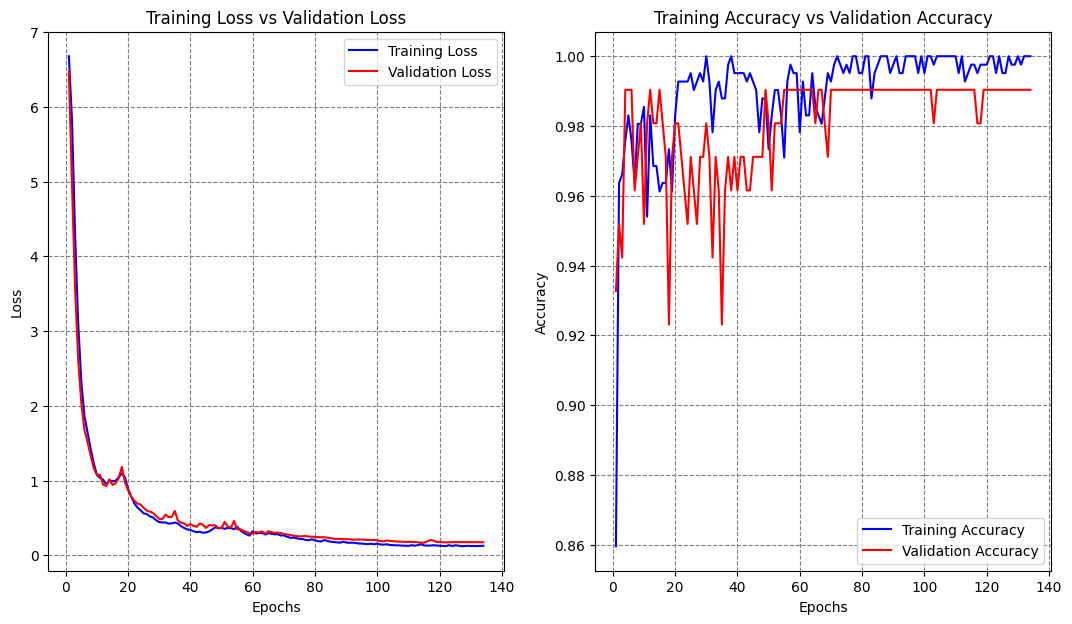

In [ ]:
# Plot the history
plot_history(Xception_model_history, model_name)

### Evaluate Model on Test data

In [ ]:
# Make predictions on the test set
Xception_y_pred = Xception_model.predict(test_images)

5/5 [==============================] - 2s 254ms/step


In [ ]:
# Calculate scores
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
Xception_accuracy = accuracy_score(test_labels, Xception_y_pred.round())
Xception_sensitivity = recall_score(test_labels, Xception_y_pred.round())
Xception_specificity = recall_score(test_labels, Xception_y_pred.round(), pos_label=0)
Xception_f1 = f1_score(test_labels, Xception_y_pred.round())
Xception_roc = roc_auc_score(test_labels, Xception_y_pred)

In [ ]:
# Print the results
print("Scores of Xception Model")
print("==================================================")
print("Xception_Accuracy score: %.4f" % (Xception_accuracy))
print("Xception_Sensitivity score: %.4f" % (Xception_sensitivity))
print("Xception_Specificity score: %.4f" % (Xception_specificity))
print("Xception_F1 score: %.4f" % (Xception_f1))
print("Xception_roc_auc score: %.4f" % (Xception_roc))
print("==================================================")

Scores of Xception Model
Xception_Accuracy score: 0.9692
Xception_Sensitivity score: 0.9744
Xception_Specificity score: 0.9670
Xception_F1 score: 0.9500
Xception_roc_auc score: 0.9955


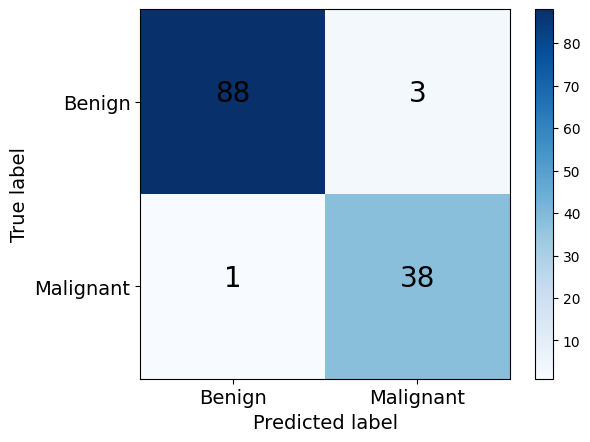

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(test_labels, Xception_y_pred, model_name)

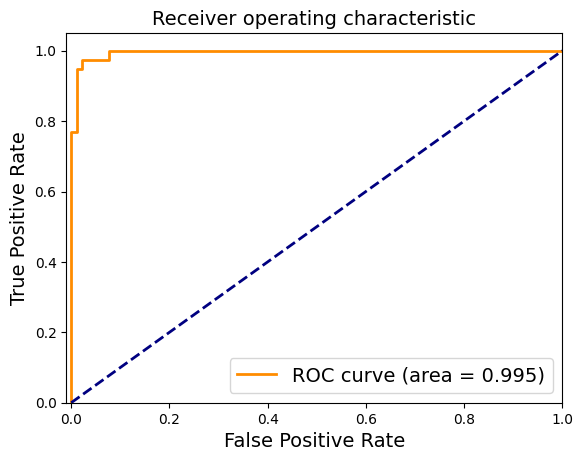

In [ ]:
# Plot ROC Curve

plot_roc_curve(test_labels, Xception_y_pred, model_name)

# Combined Results

In [ ]:
# Plot ROC Curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_preds, model_names):
    plt.figure(figsize=(8, 6))

    for i, y_pred in enumerate(y_preds):
        # Calculate the false positive rate and true positive rate for the ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve for the current model
        plt.plot(fpr, tpr, lw=2, label='%s (AUC = %0.3f)' % (model_names[i], roc_auc))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic', fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    plt.savefig("ROC_Curve.png", dpi=300)
    plt.show()


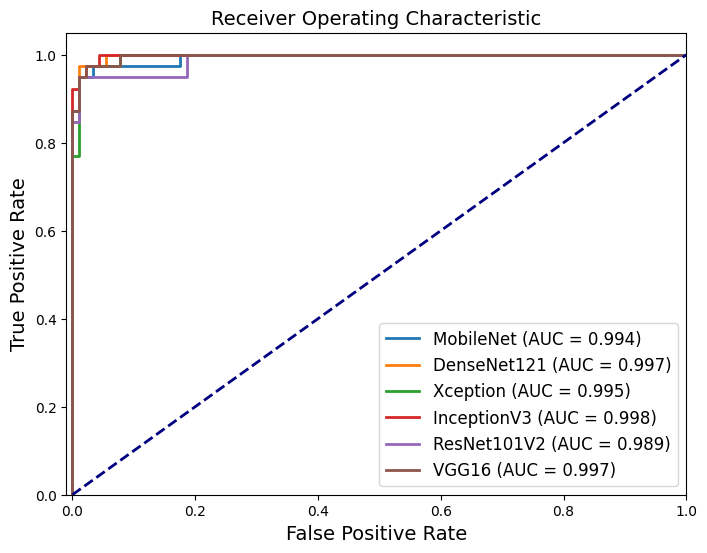

In [ ]:
# Assuming you have a list of model names corresponding to the predictions
model_names = ["MobileNet", "DenseNet121", "Xception", "InceptionV3", "ResNet101V2", "VGG16"]

# Assuming you have a list of predictions for each model
y_preds = [MobileNet_y_pred, DenseNet121_y_pred, Xception_y_pred, InceptionV3_y_pred, ResNet101V2_y_pred, VGG16_y_pred]

# Call the function to plot ROC curves for all models
plot_roc_curve(test_labels, y_preds, model_names)